# **Python for Finance, Session 2  - Solutions**
---
<img src="http://www.doc.ic.ac.uk/~afd/images/logo_imperial_college_london.png" align = "left" width=200>
 <br><br><br><br>
 
- Copyright (c) Antoine Jacquier, 2021. All rights reserved

- Author: Antoine Jacquier <a.jacquier@imperial.ac.uk>

- Platform: Tested on Windows 10 with Python 3.7

## Discrete versus continuous compounding¶


In [1]:
import numpy as np
import matplotlib.pylab as plt

In [3]:
def returns(P, r, T, n):
    """
    P: nominal amount
    r: risk-free rate per period
    T: maturity
    n: number of periods
    """
    return P*(1.+r/n)**(n*T)

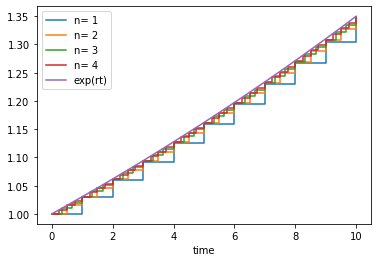

In [4]:
P0, r, T = 1, .03, 10.
nn = range(1, 5)

for n in nn:
    step = 1./float(n)
    t = 0.
    tt, pp = [], []
    for i in range(1, 1+int(n*T)):
        t = i*step
        tminus = t-step
        pminus = P0*(1.+r/n)**(n*(tminus))
        P = returns(P0, r, t, n)
        tt.extend((tminus, t, t))
        pp.extend((pminus, pminus, P))
    plt.plot(tt, pp, label='n= %d' %n)
    
plt.plot(tt, [P0*np.exp(r*t) for t in tt], label='exp(rt)')
plt.xlabel("time")
plt.legend(loc="best")
plt.show()

## Option Pricing

In [5]:
from scipy.stats import norm
import numpy as np
import matplotlib.pylab as plt

### Reference price (closed-form), see lectures

In [6]:
def blackscholesCall(s0, K, sigma, T):
    '''
    #Inputs:
    s0: initial stock price
    K: strike
    sigma: instantaneous volatility
    T: time to maturity
    #Output:
    Black-Scholes Call price
    '''
    sigT = sigma*np.sqrt(T)
    k = np.log(K/s0)
    dp = -k / sigT + 0.5*sigT
    dm = dp - sigT
    return s0*(norm.cdf(dp) - np.exp(k)*norm.cdf(dm))

### Reference Price

In [7]:
s0, K, sigma, T = 100., 100., 0.1, 1.

In [8]:
print("Reference Price: ", blackscholesCall(s0, K, sigma, T))

Reference Price:  3.9877611676744973


### Pricing by integration

In [9]:
from scipy.integrate import quad, simps

In [11]:
def integrand(x, s0, K, sigma, T):
    gaussianDensity = np.exp(-.5*x*x) / np.sqrt(2.*np.pi)
    payoffFunction = np.maximum(s0*np.exp((-.5*sigma*sigma*T + sigma*np.sqrt(T)*x))-K, 0.)
    return payoffFunction * gaussianDensity

In [13]:
print('Black-Scholes Call price by integration:')
xMin, xMax = -5., 5.

qf = quad(integrand, xMin, xMax, args=(s0, K, sigma, T,))

xx = np.linspace(xMin, xMax, 1000)
qs = simps([integrand(x, s0, K, sigma, T) for x in xx], xx)

print("Quadrature: ", qf)
print("Simpson: ", qs)
print("***************************")

Black-Scholes Call price by integration:
Quadrature:  (3.987741914498178, 9.018305900789526e-09)
Simpson:  3.987758544829223
***************************


### Pricing by simulation

In [26]:
def blackscholes_simul(s0, K, T, sigma, n):
    """
    Monte Carlo simulation for the Black-Scholes Call price function
    Note that we only simulate the random variable S_T, 
    but not the paths of the process (S_t) over the interval [0,T]
    This is justified since the Call price only depends on the distribution
    of the stock price at time T.
    
    n: number of simulations
    """
    nn = np.random.normal(0., 1., (n))
    S = s0*np.exp((-.5*sigma*sigma*T + sigma*np.sqrt(T)*nn))
    f = np.maximum(S-K, 0.)
    return np.mean(f)

In [27]:
nn = np.arange(1000, 100000, 100)

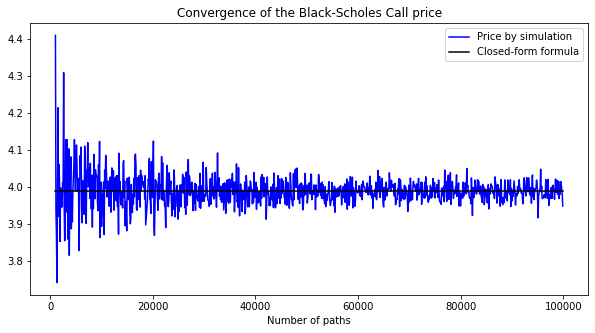

In [28]:
bb = [blackscholes_simul(s0, K, T, sigma, n) for n in nn]
trueBS = [blackscholesCall(s0, K, sigma, T)]*len(nn)

plt.figure(figsize=(10,5))
plt.plot(nn, bb, 'b', label="Price by simulation")
plt.plot(nn, trueBS, 'k', label="Closed-form formula")
plt.title("Convergence of the Black-Scholes Call price")
plt.xlabel("Number of paths")
plt.legend(loc="best")
plt.show()

## Implied volatility

In [44]:
from scipy.optimize import fsolve, root, minimize

def f(sigma, *args):
    s0, K, T, optionPrice = args ## optional arguments, where optionPrice is the Call option price to match
    return (blackscholesCall(s0, K, sigma, T)-optionPrice) ## define the objective equation to solve 

optionPrice = 3.9

impliedVol = fsolve(f, x0=0.3, args=((s0, K, T, optionPrice, )))[0]
print("Implied volatility: %.2f" %(100.*impliedVol), "%")

print("Verifying that Black-Scholes(implied volatility) = optionPrice")
print("Verification error: ", optionPrice - blackscholesCall(s0, K, impliedVol, T))

Implied volatility: 9.78 %
Verifying that Black-Scholes(implied volatility) = optionPrice
Verification error:  7.549516567451064e-15
